In [57]:
%matplotlib notebook

import glob
import random
import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
import sys
np.set_printoptions(threshold=sys.maxsize)

In [58]:
#NOTE: Change path to dataset folder
imgs = [cv2.imread(file) for file in sorted(glob.glob("/home/shubot/Documents/IIITH_Academics/Mobile_Robotics/Assignments/assignment-2/q2/data_q2/images/*.png"))]
# imgs = imgs[0:200]

In [59]:
K = np.array([[7.215377000000e+02,0.000000000000e+00,6.095593000000e+02],
              [0.000000000000e+00,7.215377000000e+02,1.728540000000e+02],
              [0.000000000000e+00,0.000000000000e+00,1.000000000000e+00]])
#NOTE: Change path to ground truth
Rt_GT = np.fromfile("/home/shubot/Documents/IIITH_Academics/Mobile_Robotics/Assignments/assignment-2/q2/data_q2/ground-truth.txt", dtype=float, count=-1, sep=" ")
Rt_GT = np.reshape(Rt_GT, (-1, 3,4))

### Explanation of Normalizing image coordinates

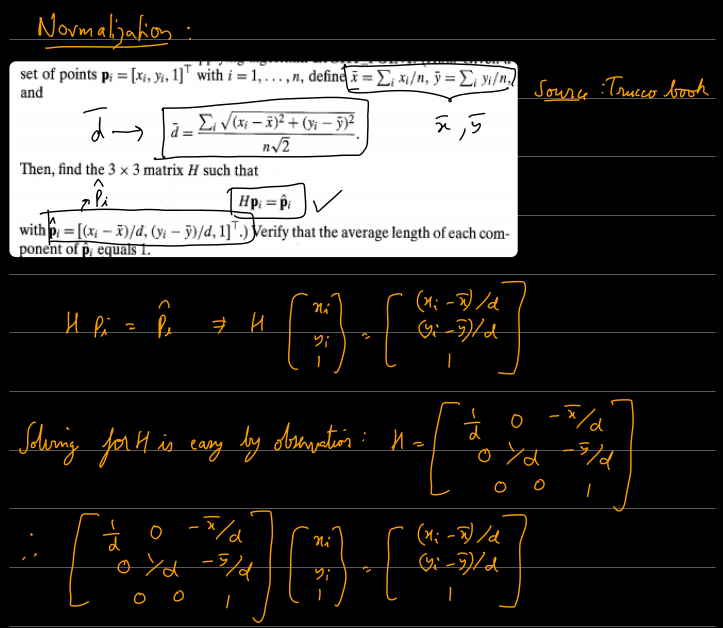

In [60]:
def normalization(pts):
    pts_av = np.mean(pts, axis=0)
    d_av = np.divide((np.sum(np.sqrt(np.sum(np.square(pts-pts_av),axis=1)),axis=0)),pts.shape[0]*np.sqrt(2))
    H = np.array([[1.0/d_av,0,-pts_av[0]/d_av],[0,1.0/d_av, -pts_av[1]/d_av],[0,0,1]])
    homo_app = np.ones((pts.shape[0],1))
    pts_h = np.hstack((pts, homo_app))
    pts_norm_homo = H @ pts_h.T
    pts_norm = np.delete(pts_norm_homo, -1,0)
    return pts_norm.T, H


# key_points = sift.detect(imgs[0])
# pts0 = np.array([x.pt for x in key_points],dtype=np.float32)
# pts1, status, _ = cv2.calcOpticalFlowPyrLK(imgs[0],imgs[0+1],pts0, None)
# status = status.reshape(status.shape[0])
# pts0 = pts0[status == 1]
# pts1 = pts1[status == 1]
# homo_app = np.ones((pts0.shape[0],1))
# pts0_h = np.hstack((pts0, homo_app))
# pts1_h = np.hstack((pts1, homo_app))

# pts0_norm, H_0 = normalization(pts0)
# print(pts0.shape, pts0[5], pts0_norm.shape, pts0_norm[40], np.sum((pts0_norm), axis=0))
# Checking if normalization works, see that np.mean outputs zero value meaning the mean is the new origin of the
# points.

**Fundamental matrix equation**
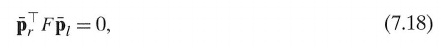

**Eight point algorithm**
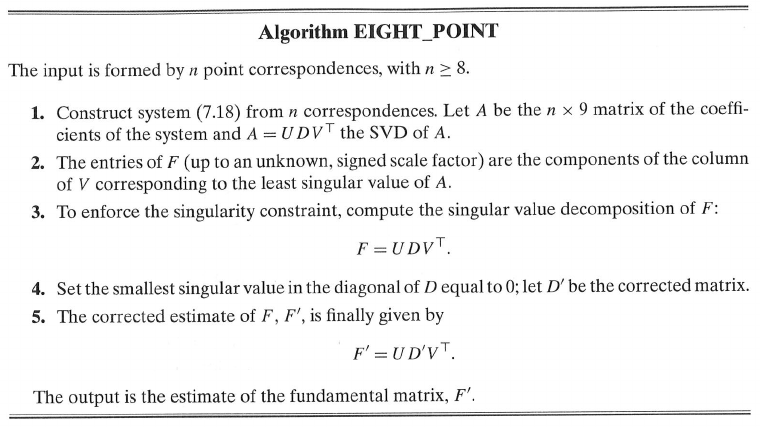

(_Source: Trucco, Introductory Techniques for 3D Vision_)

The following function codes the eight point algorithm which estimates the Fundamental matrix given a set of correspondences, i.e. pts0 and pt1 of two images. The steps in the algorithm are shown in the above image, more details are explained as comments in the function at every step at "#REPORT: 8_point Step 1 to 5".


p, e and s are parameters of RANSAC where p is success rate, e is outlier ratio, s is num of correspondences. s>=8, as we need a minimum of 8 points for estimating Fundamental matrix. Error will decrease with increase in s at the expense of computational cost. After a bit of experimentation, the success rate "p" was chosen to be 0.9 with outlier ratio "e" as 0.05. The error decreased with increase in "s" but it was very computationally intensive if s>20. More details are explained as comments in the function at every step at "# REPORT: RANSAC Step 1 to 4".


In [61]:
def findFundamentalMat(pts0, pts1, p=0.9, e=0.05, s=8):
    """ Fundamental matrix estimation with RANSAC. p,e,s are RANSAC parameters. p is success 
    rate, e is outlier ratio, s is num of correspondences. s>=8, play around with s value first.
    Error will decrease with increase in s at the expense of computational cost."""
    
    homo_app = np.ones((pts0.shape[0],1))
    pts0_h = np.hstack((pts0, homo_app))
    pts1_h = np.hstack((pts1, homo_app))
    
    A = np.zeros((s,9))
    F_final = np.zeros((3,3))
    error_init = 1000 #Initializing with high error

    
    # REPORT: RANSAC Step 1: Calculate the number of trials T using this formulation with p, e and
    # s,e and p explained above.
    T = int(np.log(1-p)/np.log(1-((1-e)**s)))

    # REPORT: RANSAC Step 2: In the outer loop, we are running T iterations and selecting
    # the F matrix with least error.
    for k in range(T):
        # REPORT: 8_point Step 1a of algorithm, i.e. constructing A = n X 9.
        # REPORT: RANSAC Step 3: Randomly sampling n corresponding points. "j" -> (1,n)
        for i in range(A.shape[0]):
            j = random.randint(0, pts0.shape[0]-1)
            A[i] = np.array([pts1[j][0] * pts0[j][0], pts1[j][0] * pts0[j][1],pts1[j][0],
                          pts1[j][1] * pts0[j][0], pts1[j][1] * pts0[j][1], pts1[j][1], 
                          pts0[j][0], pts0[j][1],1])

        # REPORT: 8_point Step 1b  and 2 of algorithm, i.e.
        # calculating SVD of A: F upto a signed scale factor equals V.T last row.
        (Ua, Da, Vha) = np.linalg.svd(A, full_matrices=True)
        ha = Vha[-1,:]
        F = ha.reshape(3,3)
        
        # REPORT: 8_point Step 3 of algorithm: Computing SVD of F.
        (Uf, Df, Vhf) = np.linalg.svd(F, full_matrices=True)
        Df_corrected = np.zeros((3,3))
        # REPORT: 8_point Step 4 of algorithm: Setting smallest singular value as 0
        # D' the corrected matrix is Df_corrected.
        Df[2] = 0.000
        np.fill_diagonal(Df_corrected, Df)
        # REPORT: 8_point Step 5 of algorithm: Corrected estimate of F, i.e. F' which
        # is here F_corrected.
        F_corrected = Uf @ Df_corrected @ Vhf
        
        # REPORT: RANSAC Step 4: Calculating error. X' F X should ideally be equal
        # to zero if F is completely accurate. Higher the inaccuracy, farther the value
        # will be from 0. So we are taking mean of absolute value of (X' F X) as 
        # the error.
        zero_all = (pts1_h @ F_corrected @ pts0_h.T)
        # This will actually give a 3200 * 3200 vector, what we need is one to one img correspondences
        # i.e. diag of zero_all
        error = np.mean(np.abs(np.diag(zero_all)))
        if error < error_init:
            error_init = error
            F_final = F_corrected
    return F_final, error_init

In [62]:
# Main Code start. Finding SIFT features, then estimating F and then R,t.

Rs = []; ts = []

sift = cv2.xfeatures2d.SIFT_create()
error_all = np.array([])

for i in range(len(imgs)-1):
    # REPORT: Extracting keypoints using SIFT and tracking them using Optical flow.
    key_points = sift.detect(imgs[i])
    pts0 = np.array([x.pt for x in key_points],dtype=np.float32)
    pts1, status, _ = cv2.calcOpticalFlowPyrLK(imgs[i],imgs[i+1],pts0, None)
    status = status.reshape(status.shape[0])
    pts0 = pts0[status == 1]
    pts1 = pts1[status == 1]

    # REPORT: 8_point Step 0 of algorithm: Normalizing the image coordinates.
    pts0_norm, H_0 = normalization(pts0)
    pts1_norm, H_1 = normalization(pts1)
    
#     F, mask = cv2.findFundamentalMat(pts0, pts1,method=cv2.FM_RANSAC)
#     F_unnorm, mask = cv2.findFundamentalMat(pts0_norm, pts1_norm,method=cv2.FM_RANSAC)
    F_unnorm, error = findFundamentalMat(pts0_norm, pts1_norm,p=0.9, e=0.05, s=20) #p,e,s are RANSAC parameters
#     F, error = findFundamentalMat(pts0, pts1,p=0.9, e=0.05, s=8) #p,e,s are RANSAC parameters
    error_all = np.append(error_all, error)
    
    # REPORT: Obtaining Essential matrix from Fundamental matrix and decomposing Essential
    # into Rt.
    F = np.transpose(H_1) @ F_unnorm @ (H_0)
    
    E = K.T @ F @ K
    Rt = cv2.recoverPose(E, pts0, pts1, K)
    
    Rs.append(Rt[1]) 
    ts.append(Rt[2])
    
error_avg = np.mean(error_all)
print("The average error is {}".format(error_avg))
#The average error is 0.012156663009381407: p=0.9, e=0.05, s=8
#The average error is 0.006826024612130262: p=0.9, e=0.05, s=20
#The average error is 0.006163539398894047: p=0.9, e=0.05, s=35
#The average error is 0.006001110316292531: p=0.95, e=0.05, s=40
#The average error is 0.005913606194329991: p=0.9, e=0.05, s=50

The average error is 0.012156663009381407


## Getting relative poses with respect to world  

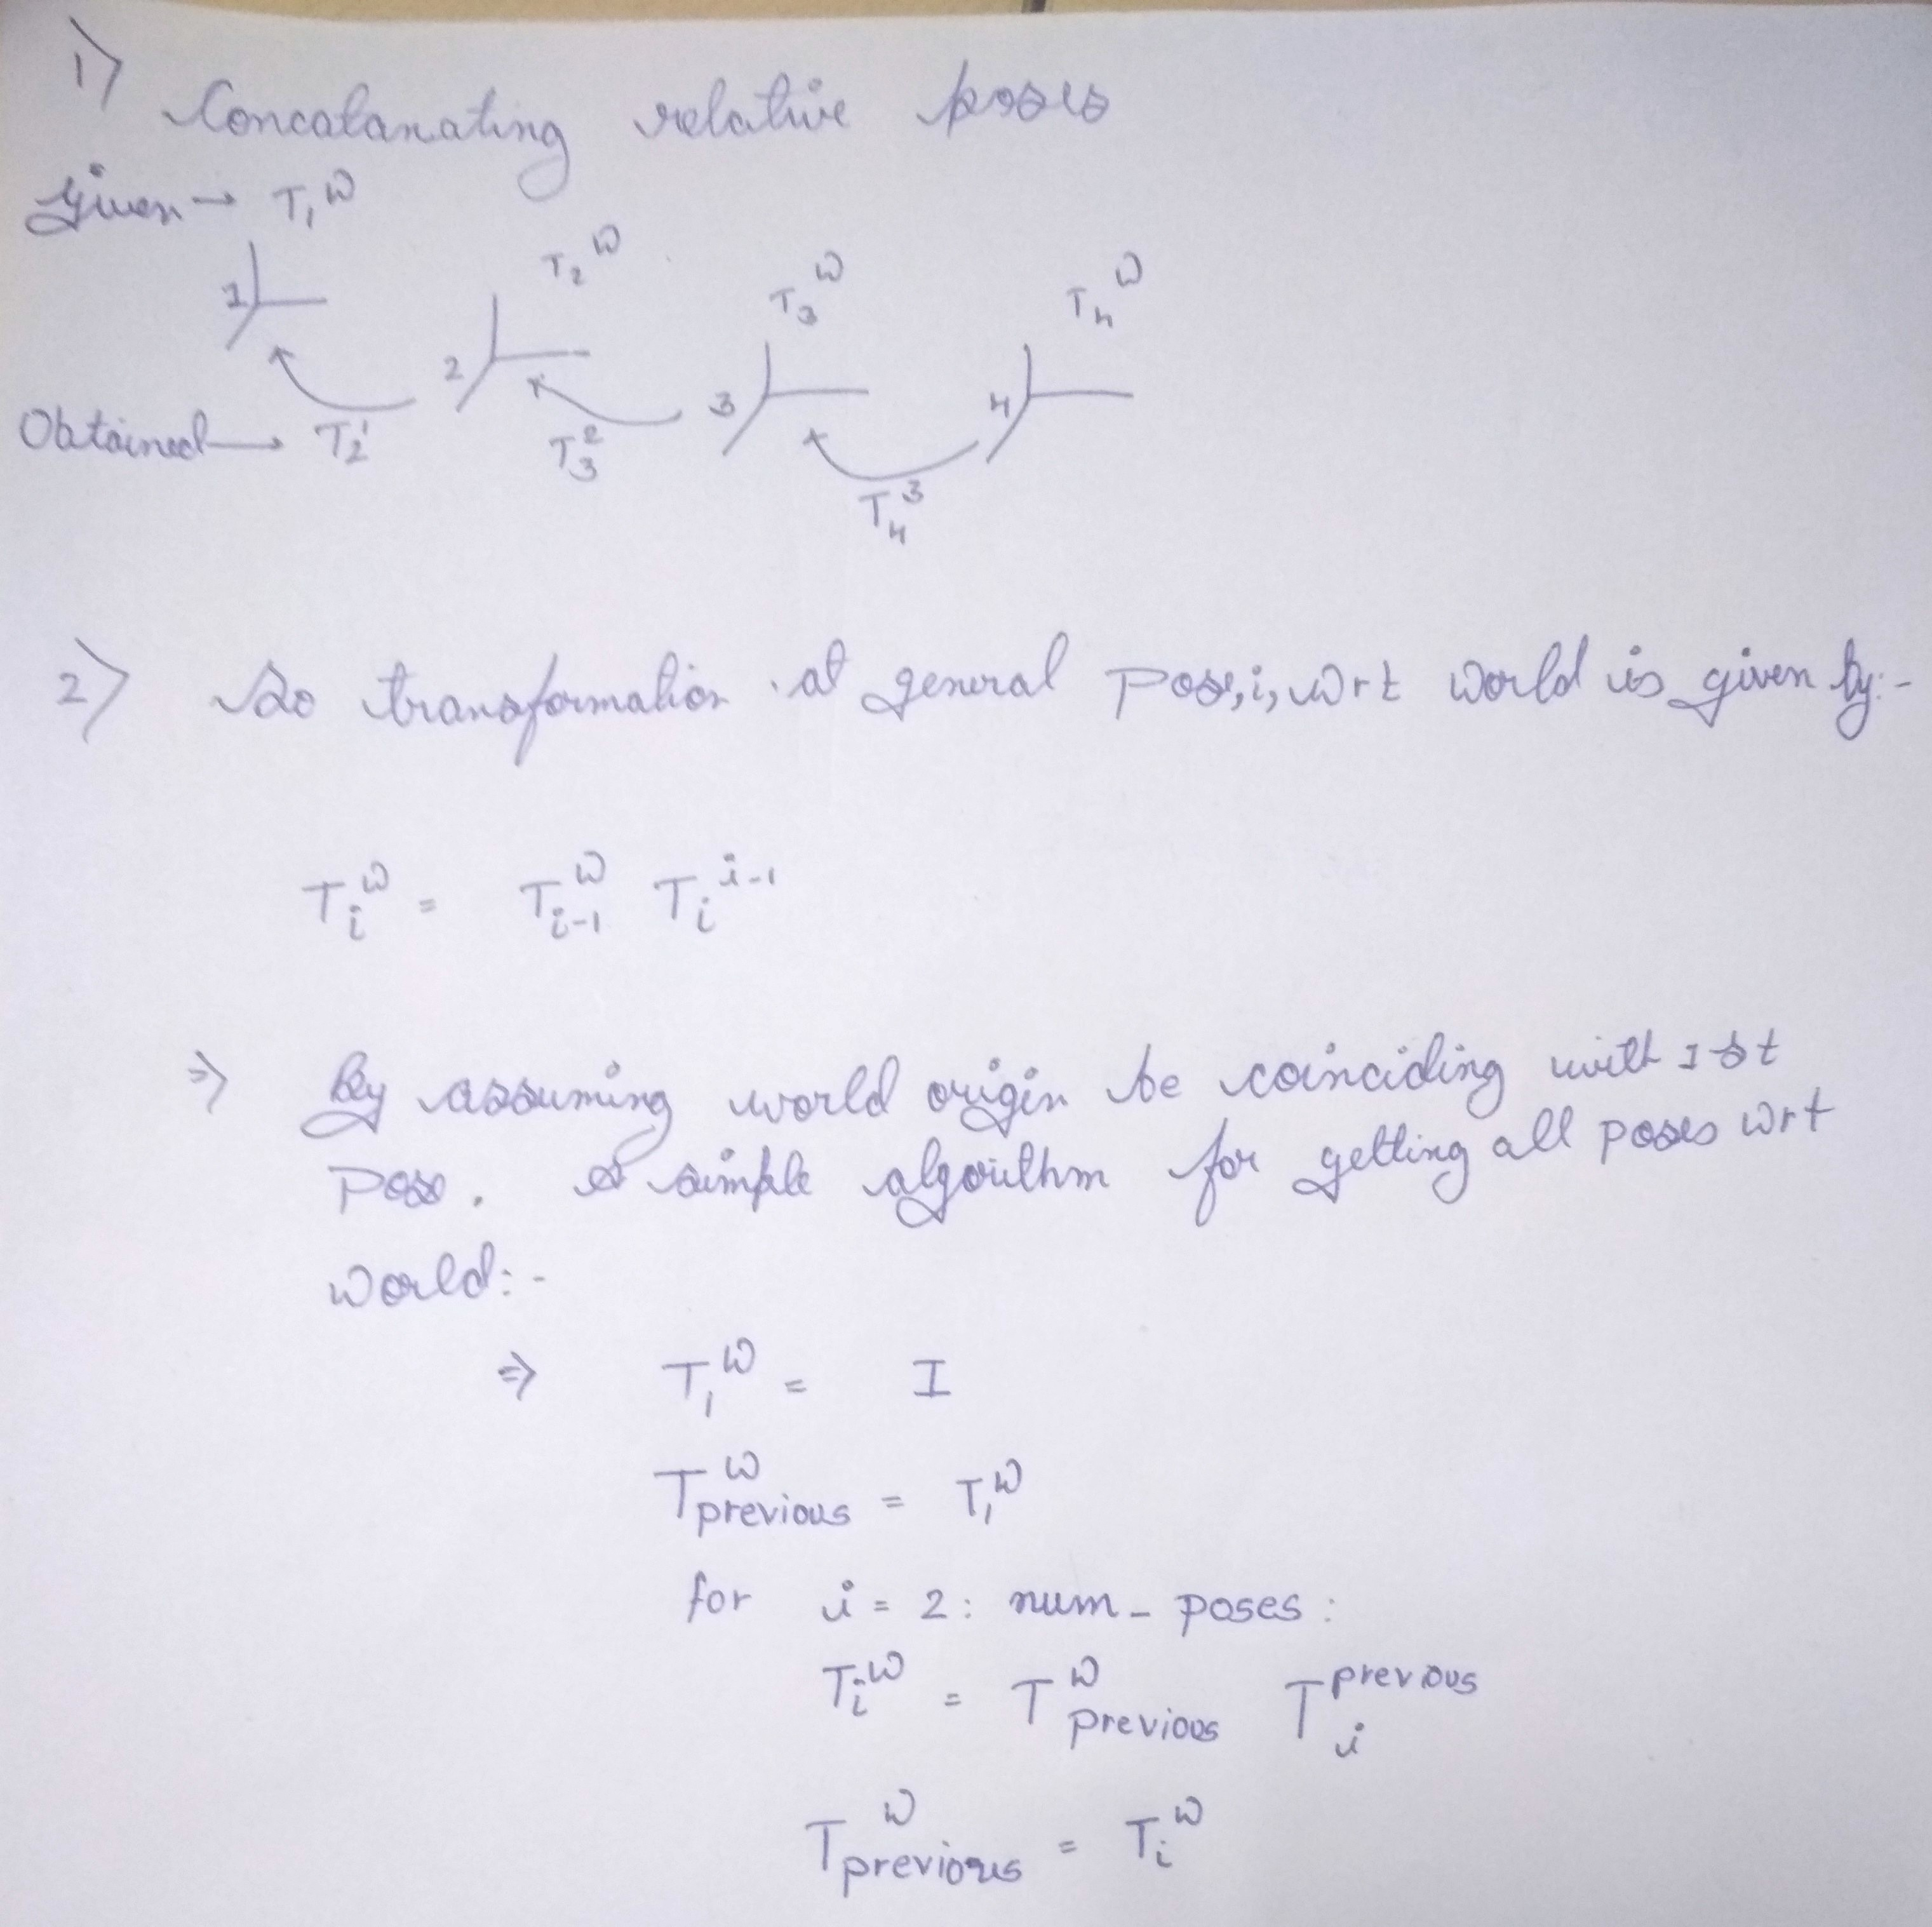

In [63]:
# Scaling translation using relative ground truth transformation

tsRect = []

for i in range(1, len(imgs)):
    Ti_w = np.vstack((Rt_GT[i], np.array([0, 0, 0, 1])))
    Tp_w = np.vstack((Rt_GT[i-1], np.array([0, 0, 0, 1])))
    Tp_i = np.linalg.inv(Ti_w) @ Tp_w
    
    scale = np.linalg.norm(Tp_i[0:3, 3])
    tsRect.append(scale*ts[i-1])

In [64]:
# Generate transfomation matrices by stacking R and t

Ts = []
Ts.append(np.eye(4))

for i in range(len(Rs)):
    Tp_i = np.vstack((np.hstack((Rs[i], tsRect[i])), np.array([0, 0, 0, 1])))
    Ti_p = np.linalg.inv(Tp_i)

    Ts.append(Ti_p)


In [65]:
# Tp_w = p wrt w
# Saving all points wrt to world for evo evaluation

poses = open('./vo_poses_8.txt', 'w')
# poses = open('/home/shubot/Documents/IIITH_Academics/Mobile_Robotics/Assignments/assignment-2/q2/data_q2/vo_poses.txt', 'w')

T0_w = Ts[0]
Tp_w = T0_w

# Write 0th pose
line = T0_w.reshape(16, 1)
for i in range(12):
    num = str(line[i, 0])
    poses.write(num)
    if(i != 11):
        poses.write(" ")
poses.write("\n")
    
for i in range(1, len(imgs)):
    Ti_p = Ts[i]
    Ti_w = np.dot(Tp_w, Ti_p)
       
    # Write ith pose    
    line = Ti_w.reshape(16)
    for i in range(12):
        num = str(line[i])
        poses.write(num);
        if(i != 11):
            poses.write(" ")
    poses.write("\n")
    
    Tp_w = Ti_w

poses.close()

<IPython.core.display.Javascript object>


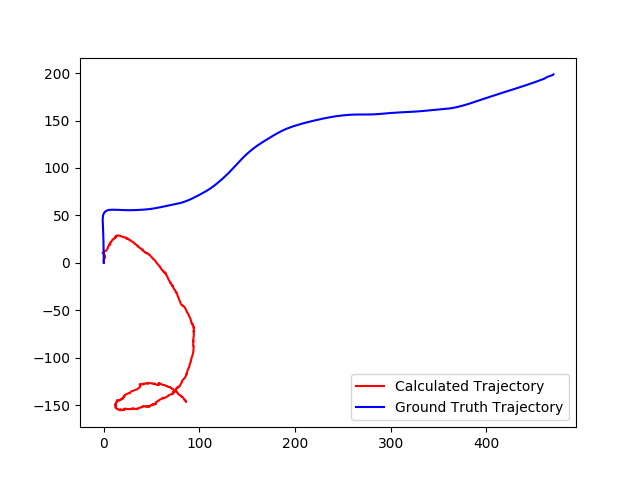

In [66]:
# Plotting trajectory obtained with respect to ground truth


X1 = []; Z1 = []
X2 = []; Z2 = []


T0_w = Ts[0]
Tp_w = T0_w

X1.append(T0_w[0, 3])
Z1.append(T0_w[2, 3])

X2.append(Rt_GT[0, 0, 3])
Z2.append(Rt_GT[0, 2, 3])

for i in range(1, len(imgs)):
    Ti_p = Ts[i]
    Ti_w = np.dot(Tp_w, Ti_p)
    
    X1.append(Ti_w[0, 3])
    Z1.append(Ti_w[2, 3])
    
    X2.append(Rt_GT[i, 0, 3])
    Z2.append(Rt_GT[i, 2, 3])
    
    Tp_w = Ti_w

plt.plot(X1, Z1, 'r-', label="Calculated Trajectory")
plt.plot(X2, Z2, 'b-', label="Ground Truth Trajectory")
plt.legend(loc='lower right')
plt.show()

# RESULTS

The algorithm works well at the initial part of the trajectory. It is very close to ground truth till it takes the sharp right turn where it starts to diverge from the ground truth. This could be because it has most of old features might have been lost and it might have been difficult to track the remaining few features, which would adversely affect the F matrix estimation down the pipeline. However, although the trajectory has diverged already, the calculated trajectory also turns eventually at similar intervals as the ground truth.

#### RANSAC Tuning results

**The average error is 0.012156663009381407: p=0.9, e=0.05, s=8.        
The average error is 0.006826024612130262: p=0.9, e=0.05, s=20.    
The average error is 0.006163539398894047: p=0.9, e=0.05, s=35.    
The average error is 0.006001110316292531: p=0.95, e=0.05, s=40.  
The average error is 0.005913606194329991: p=0.9, e=0.05, s=50. (imgs below corresponds to this)**

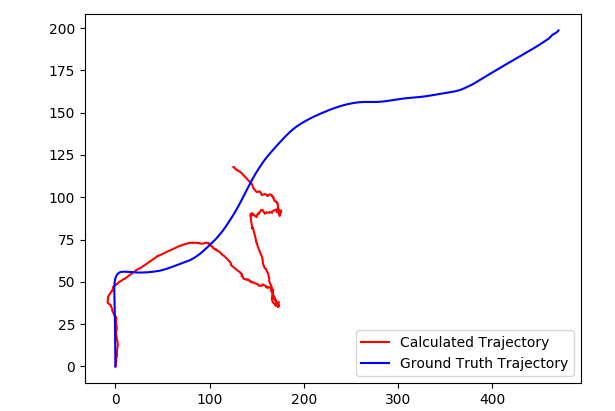

### EVO Results



*Note: EVO with first 300 poses aligned. Same config (p=0.9, e=0.05, s=50.) as mentioned above.

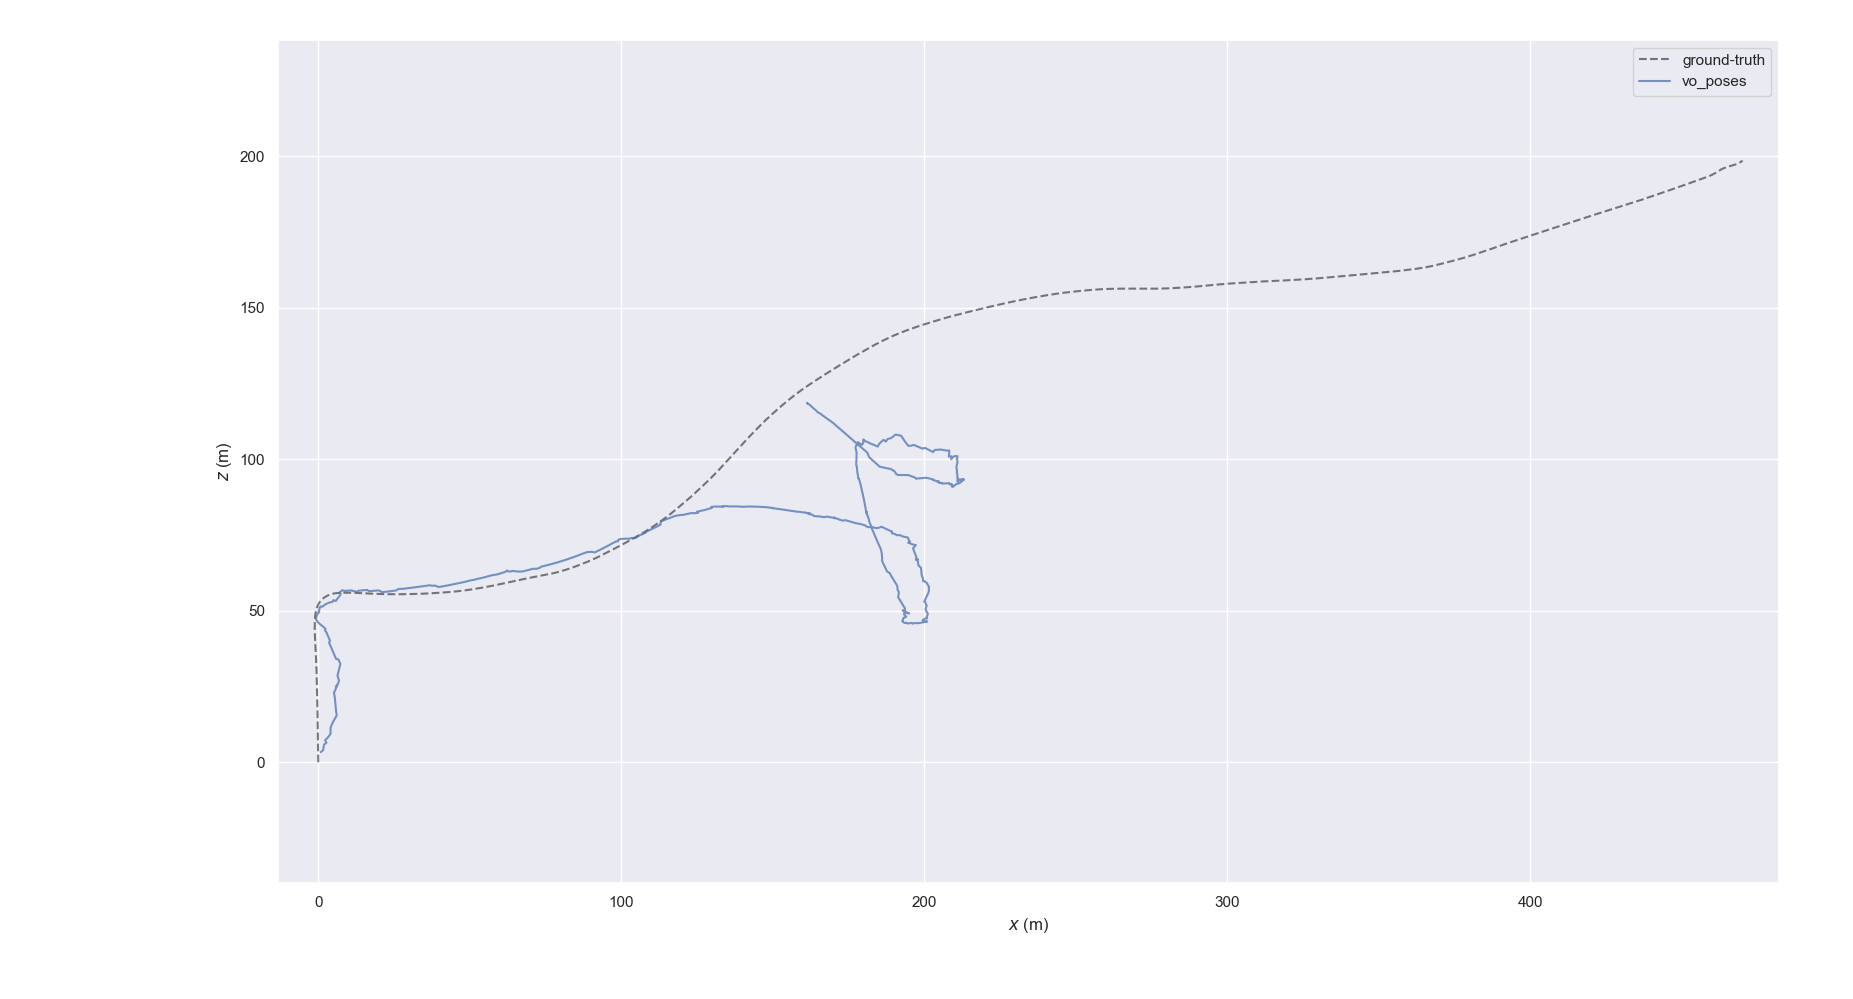

#### APE
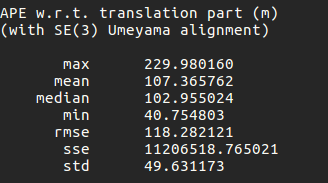

#### RPE
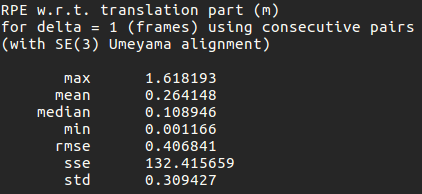